In [ ]:
import os
import cv2

def load_inria_dataset(pos_dir, neg_dir, image_size=(32, 96)):  #(128,64)
    positive_patches = []
    negative_patches = []

    # 正样本
    for file in os.listdir(pos_dir):
        img_path = os.path.join(pos_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            positive_patches.append(img)

    # 负样本
    for file in os.listdir(neg_dir):
        img_path = os.path.join(neg_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            negative_patches.append(img)

    return positive_patches, negative_patches

# 数据路径
train_pos_dir = r"C:\Users\jixia\Desktop\peopleDet\Train_Test\train\pos33\aa"  # 人体
train_neg_dir = r"C:\Users\jixia\Desktop\peopleDet\Train_Test\train\neg33"  # 非人体
test_pos_dir = r"C:\Users\jixia\Desktop\peopleDet\Train_Test\test\pos11"  # 人体
test_neg_dir = r"C:\Users\jixia\Desktop\peopleDet\Train_Test\test\neg11"  # 非人体

# 加载数据
train_positive_patches, train_negative_patches = load_inria_dataset(train_pos_dir, train_neg_dir)
test_positive_patches, test_negative_patches = load_inria_dataset(test_pos_dir, test_neg_dir)
print(f"Loaded {len(train_positive_patches)} positive samples and {len(train_negative_patches)} negative samples.")
print(f"Loaded {len(test_positive_patches)} positive samples and {len(test_negative_patches)} negative samples.")

In [ ]:
import numpy as np
from skimage.feature import hog
from itertools import chain
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import joblib

"""
hog(image, 输入图片
    orientations=9, 直方图横坐标长度
    pixels_per_cell=(8, 8), 每个cell的像素数
    cells_per_block=(3, 3), 每个block的cell数   
    block_norm='L2-Hys', block归一化方法 
    visualize=False, 是否可视化
    transform_sqrt=False, 是否对梯度幅值进行平方根变换
    feature_vector=True, 是否将HOG特征展平为一维向量
    *, 
    channel_axis=None) 

LinearSVC 线性支持向量机
    dual=False, 是否使用对偶形式
    max_iter=10000, 最大迭代次数
    C=1.0, 正则化参数
StandardScaler 计算均值和标准差，然后对数据进行标准化
joblib 保存和加载模型
"""

# 加载数据集
# positive_patches: 包含人体的正样本；negative_patches: 不包含人体的负样本
X_train = np.array([hog(im) for im in chain(train_positive_patches, train_negative_patches)])
y_train = np.hstack([np.ones(len(train_positive_patches)), np.zeros(len(train_negative_patches))])
X_test = np.array([hog(im) for im in chain(test_positive_patches, test_negative_patches)])
y_test = np.hstack([np.ones(len(test_positive_patches)), np.zeros(len(test_negative_patches))])

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, r"models\scaler3.pkl")
# 训练 SVM 模型
# svm = LinearSVC(dual=False, max_iter=10000)
svm = LinearSVC(C=1.0, max_iter=1000)
svm.fit(X_train, y_train)
joblib.dump(svm, r"models\svm3.pkl")

print(f"Training Accuracy: {svm.score(X_train, y_train)}")
print(f"Test Accuracy: {svm.score(X_test, y_test)}")

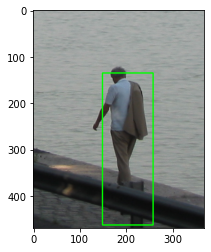

In [41]:
import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from imutils.object_detection import non_max_suppression


def sliding_window(image, step_size, window_size):
    # 滑动窗口
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])
            # print(x,y,image[y:y + window_size[1], x:x + window_size[0]].shape)

def pyramid(image, scale=1.5, min_size=(64, 128)): # w,h
    # 图像金字塔
    yield image
    while image.shape[0] > min_size[1] and image.shape[1] > min_size[0]:
        image = cv2.resize(image, 
                           (int(image.shape[1] / scale), int(image.shape[0] / scale)), 
                           interpolation=cv2.INTER_LINEAR)
        yield image

def adjust_detection_boxes(detections):
    # 调整检测框
    adjusted_boxes = []
    for (x1, y1, x2, y2, scale) in detections:
        adjusted_boxes.append((int(x1 * scale), int(y1 * scale), int(x2 * scale), int(y2 * scale)))
    return adjusted_boxes

# 检测
def detect(image, svm, scaler, window_size, step_size, threshold):
    detections = []
    for resized_image in pyramid(image):
        scale = image.shape[0] / float(resized_image.shape[0])  # 计算当前金字塔层的缩放比例
        for (x, y, window) in sliding_window(resized_image, step_size, window_size):
            if window.shape[:2] != (window_size[1], window_size[0]):  # 只对相应的窗口进行检测
                continue
            # 提取 HOG 特征
            features = hog(window, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
            features = scaler.transform([features])
            # SVM 预测
            dis = svm.decision_function(features)
            if dis > threshold:  # 阈值，实际为计算的样本特征点到决策边界的距离
                detections.append((x, y, x + window_size[0], y + window_size[1], scale))
    detections = adjust_detection_boxes(detections)
    return detections

def nms(detections, overlap_thresh):
    rects = np.array([[x, y, x_end, y_end]for (x, y, x_end, y_end) in detections])
    return non_max_suppression(rects, probs=None, overlapThresh=overlap_thresh)


imgp = r"test_imgs\img3.png"
image111 = cv2.imread(imgp)
image = cv2.imread(imgp, cv2.IMREAD_GRAYSCALE)
scaler = joblib.load(r"models\scaler3.pkl")
svm = joblib.load(r"models\svm3.pkl")
# 阈值
threshold = 2
# 滑动窗口大小
window_size = (32, 96)  # 数据集的窗口大小也是32*96
# 滑动步长  
step_size = 4
# nms阈值
overlap_thresh = 0.1

detections = detect(image, svm, scaler, window_size, step_size, threshold)
final_detections = nms(detections, overlap_thresh)

for (x, y, x_end, y_end) in final_detections:
    cv2.rectangle(image111, (x, y), (x_end, y_end), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image111, cv2.COLOR_BGR2RGB))
plt.show()